<a href="https://colab.research.google.com/github/kapitalistka/SberSchoolGroupProject/blob/main/%D0%93%D1%80%D1%83%D0%BF%D0%BF%D0%BE%D0%B2%D0%BE%D0%B9_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Групповой проект 2
[Соревнование на Kaggle](https://www.kaggle.com/c/ieee-fraud-detection/overview)
In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.

The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

Categorical Features - Transaction
ProductCD
card1 - card6
addr1, addr2
P_emaildomain
R_emaildomain
M1 - M9
Categorical Features - Identity
DeviceType
DeviceInfo
id_12 - id_38
The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).


## Все импорты ноутбука здесь

In [1]:
!pip install -q catboost shap

     |████████████████████████████████| 76.1 MB 1.2 MB/s 
     |████████████████████████████████| 564 kB 69.0 MB/s 


In [2]:
import catboost as cb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression, SGDClassifier, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import zipfile
import random
import os
import gc
from functools import partial
import requests
import io
import base64
import pickle

## Загрузка данных

Files
- train_{transaction, identity}.csv - the training set
- test_{transaction, identity}.csv - the test set (you must predict the isFraud value for these observations)
- sample_submission.csv - a sample submission file in the correct format

> Загружаем данные из zip-архива, так как в распакованном виде они больше гигабайта

In [ ]:
# Генерация ссылки на загрузку по share link onedrive
def create_onedrive_directdownload (onedrive_link):
    data_bytes64 = base64.b64encode(bytes(onedrive_link, 'utf-8'))
    data_bytes64_String = data_bytes64.decode('utf-8').replace('/','_').replace('+','-').rstrip("=")
    resultUrl = f"https://api.onedrive.com/v1.0/shares/u!{data_bytes64_String}/root/content"
    return resultUrl

In [ ]:
# Загрузка csv из zip
def csv_from_zip(csv_file, zip_file='./ieee-fraud-detection.zip', **kwargs):
   with zipfile.ZipFile(zip_file) as z:
      with z.open(csv_file) as f:
         return pd.read_csv(f, **kwargs)

In [ ]:
%%time
train_transaction = csv_from_zip('train_transaction.csv', delimiter=',')
train_identity = csv_from_zip('train_identity.csv', delimiter=',')

test_transaction = csv_from_zip('test_transaction.csv', delimiter=',')
test_identity = csv_from_zip('test_identity.csv', delimiter=',')
# Сразу исправляем ошибку с названиями столбцов
test_identity.columns = test_identity.columns.str.replace('id-', 'id_')

CPU times: user 47.9 s, sys: 17.1 s, total: 1min 5s
Wall time: 1min 5s


In [ ]:
print(
    f'''
    Размеры выборок, (объекты, признаки).
    - Обучающие: transaction {train_transaction.shape}, identity {train_identity.shape}
    - Тестовые: transaction {test_transaction.shape}, identity {test_identity.shape}
    ''')


    Размеры выборок, (объекты, признаки).
    - Обучающие: transaction (590540, 394), identity (144233, 41)
    - Тестовые: transaction (506691, 393), identity (141907, 41)
    


## Разбиваем train_transaction на X и y. Где y - это целевая переменная

In [ ]:
X = train_transaction.drop(["isFraud"],axis=1)
y = train_transaction["isFraud"]

## Полезные функции по обработке данных. Чтобы потом можно было их использовать в пайплайнах

In [3]:
# Установка seed для всех случайных счетчиков
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 0xBEEF
seed_everything(SEED)

In [4]:
# Вспомогательная функция, которая позволяет объединять несколько шагов 
# по трансформации матриц (или других объектов) в один пайплайн
def make_transformer(*transformers):
    def transformer(*args):
        for t in transformers:
            try:
                args = t(args)
            except:
                args = t(*args)
        return args
    return transformer

In [5]:
# Объединение Train и Test в один датафрейм (для удобства, 
# чтобы обработка данных сразу применялась к Train и Test)
def combine_data(x, y):
    all = pd.concat([x, y], keys=['train', 'test'])
    return all

# Обратная операция - Разъединение, до этого объединенных данных
def split_data(data):
    return data.loc['train'], data.loc['test']

# Убираем столбец(ы) с указанным именем
def drop_column(column):
    def drop(data):
        data.drop(column, axis=1, inplace=True)
        return data
    return drop

# Добавляем identity
def merge_identity(identity):
    def merge(data):
        return data.reset_index().merge(identity, 
                                 how='left', on = 'TransactionID', 
                                 validate = 'many_to_one'
                                 ).set_index(['level_0', 'level_1'])
    return merge
    
# Cтолбцы, где слишком много пропущенных значений (выше определенного процента)
def nan_columns(data, nan_percent=0.8):
    nans = data.isna().sum()
    return nans[nans > nan_percent*len(data)].index

# Обработка категориальных признаков
# Конвертация float в string
# Замена пропущеных значений на строковые - 'nan'
def perform_cat_features(cat_features):
    def perform_cat(data):
        # Приведем все float категориальные фичи к строкам
        dtypes = data[cat_features].dtypes
        idx = dtypes == 'float64'
        cat_floats = dtypes[idx].index
        data[cat_floats] = data[cat_floats].astype(str)
        # Конвертируем все пропущенные значения в строки (для категориальных фич)
        data[cat_features] = data[cat_features].fillna('nan')
        return data
    return perform_cat

# В тестовой таблице identity ошибка в названии столбцов. Вместо id_ - id-
# Заменим в названии столбцов 'id'- на 'id_'
def fix_id_columns(data):
    data.columns = data.columns.str.replace('id-', 'id_')
    return data

# Кодируем категориальные признаки (простой способ Ordinal или Label)
def ordinal_encoding(columns):
    def encoding(data):
        oenc = OrdinalEncoder()
        data[columns] = oenc.fit_transform(data[columns])
        return data
    return encoding

# Заполняем пропуски в столбцах при помощи переданной функции
# По-умолчанию, используется мода (mode)
def fillna_with(cols=None, function=None):
    def fill_all(x):
        for c in x.columns:
            if x[c].dtype != object:
                value = function(x[c]) 
                x[c] = x[c].fillna(value)
        return x
    def fill_cols(x):
        for c in cols:
                value = function(x[c]) 
                x[c] = x[c].fillna(value)
        return x
    if function is None:
        function = lambda x: x.mode()[0]
    if cols is None:
        return fill_all
    else:
        return fill_cols

## Базовая подготовка данных для catboost

In [ ]:
# Соединим тренировочные и тестовые данные вместе, чтобы производить одновременные преобразования
all = combine_data(X, test_transaction)

In [ ]:
del X
del test_transaction
gc.collect()

176

In [ ]:
all.loc['train'].shape, all.loc['test'].shape

((590540, 393), (506691, 393))

### Добавляем identity 
1. Добавим данные из identity
1. Удалим бесполезный столбец `TransactionID`

In [ ]:
%%time
base_transform = make_transformer(
    merge_identity(pd.concat([train_identity, test_identity])),
    drop_column('TransactionID')
)

all = base_transform(all)

CPU times: user 16.7 s, sys: 10.7 s, total: 27.4 s
Wall time: 27.1 s


In [ ]:
del test_identity
del train_identity
gc.collect()

88

In [ ]:
all.loc['train'].shape, all.loc['test'].shape

((590540, 432), (506691, 432))

### Удаление столбцов, где слишком много пропущенных значений

In [ ]:
bad_columns = nan_columns(all, nan_percent=0.8)
all.drop(bad_columns, axis=1, inplace=True)
print(f'Удалено {len(bad_columns)} столбцов, где было более 80% пропущеных значений')

Удалено 74 столбцов, где было более 80% пропущеных значений


### Категориальные и числовые признаки
[Обсуждение на Kaggle](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-607486)

#### Выделение категориальных и числовых признаков

In [ ]:
cat_features = ['ProductCD'] + \
           ["card"+f"{i+1}" for i in range(6)] + \
           ["addr"+f"{i+1}" for i in range(2)] + \
           ["P_emaildomain", "R_emaildomain"] + \
           ["M"+f"{i+1}" for i in range(9)] + \
           ["DeviceType", "DeviceInfo"] + \
           ["id_"+f"{i}" for i in range(12, 39)]

# Вычтем удаленные ранее столбцы

cat_features = list(set(cat_features)- set(bad_columns))

In [ ]:
num_features = list(set(all.columns)- set(cat_features))

In [ ]:
print(f'Всего признаков = {all.shape[1]}, цифровых признаков = {len(num_features)}, категориальных = {len(cat_features)}')

Всего признаков = 358, цифровых признаков = 322, категориальных = 36


#### Подготовка категориальных признаков
cat_features must be integer or string, real number values and NaN values should be converted to string

In [ ]:
# Приведем все float категориальные фичи к строкам
dtypes = all[cat_features].dtypes
idx = dtypes == 'float64'
cat_floats = dtypes[idx].index

In [ ]:
all[cat_floats] = all[cat_floats].astype(str)

In [ ]:
# Конвертируем все пропущенные значения в строки (для категориальных фич)
all[cat_features] = all[cat_features].fillna('nan')

### Сохранение подготовленных данных в файл (Если необходимо)

In [ ]:
all.to_pickle('./catboost_all.zip')

In [ ]:
pd.to_pickle(cat_features, './cat_features.zip')

In [ ]:
pd.to_pickle(y, './y.zip')

### Загрузка данных из файла (Если необходимо)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
all = pd.read_pickle('drive/MyDrive/Data/catboost_all.zip')

In [8]:
cat_features = pd.read_pickle('drive/MyDrive/Data/cat_features.zip')

In [9]:
y = pd.read_pickle('drive/MyDrive/Data/y.zip')

In [10]:
num_features = list(set(all.columns)- set(cat_features))

## Базовый catboost

In [ ]:
train, test = split_data(all)
train.shape, test.shape

((590540, 358), (506691, 358))

### Проверка с разбиением обучающей выборки

In [ ]:
# Quick test with AUC

X_tr, X_val, y_tr, y_val = train_test_split(train, y, test_size=0.2, random_state=SEED, stratify = y)

cboost_params = {
    'loss_function': 'Logloss',
    'custom_loss':['AUC'],
    # 'logging_level':'Silent',
    'task_type' : 'GPU',
    'metric_period' : 50
    # 'early_stopping_rounds' : 100
}

simple_model = cb.CatBoostClassifier(**cboost_params)

simple_model.fit(
    X_tr, y_tr,
    cat_features=cat_features,
    eval_set=(X_val, y_val)
    )

Learning rate set to 0.04219
0:	learn: 0.6211086	test: 0.6210906	best: 0.6210906 (0)	total: 129ms	remaining: 2m 8s
50:	learn: 0.0975784	test: 0.0967504	best: 0.0967504 (50)	total: 6.03s	remaining: 1m 52s
100:	learn: 0.0809809	test: 0.0786921	best: 0.0786921 (100)	total: 11.7s	remaining: 1m 43s
150:	learn: 0.0735179	test: 0.0702121	best: 0.0702121 (150)	total: 17.3s	remaining: 1m 37s
200:	learn: 0.0696804	test: 0.0658882	best: 0.0658882 (200)	total: 22.9s	remaining: 1m 31s
250:	learn: 0.0674711	test: 0.0635365	best: 0.0635365 (250)	total: 28.6s	remaining: 1m 25s
300:	learn: 0.0658434	test: 0.0617649	best: 0.0617649 (300)	total: 34.2s	remaining: 1m 19s
350:	learn: 0.0648013	test: 0.0607724	best: 0.0607724 (350)	total: 40s	remaining: 1m 13s
400:	learn: 0.0639344	test: 0.0599337	best: 0.0599337 (400)	total: 45.6s	remaining: 1m 8s
450:	learn: 0.0633340	test: 0.0594650	best: 0.0594650 (450)	total: 51.3s	remaining: 1m 2s
500:	learn: 0.0623718	test: 0.0583856	best: 0.0583856 (500)	total: 56.9s

### Обучение catboost на всем train

In [ ]:
%%time
# Обучение на всем train
train_dataset = cb.Pool(train, y, cat_features=cat_features)

cboost_params = {
    'loss_function': 'Logloss',
    'custom_loss':['AUC'],
    'task_type' : 'GPU',
    'metric_period' : 50
}

model = cb.CatBoostClassifier(**cboost_params)
model.fit(train_dataset);

Learning rate set to 0.023733
0:	learn: 0.6532053	total: 137ms	remaining: 2m 16s
50:	learn: 0.1282914	total: 6.73s	remaining: 2m 5s
100:	learn: 0.0936660	total: 13.3s	remaining: 1m 58s
150:	learn: 0.0827408	total: 19.7s	remaining: 1m 50s
200:	learn: 0.0769608	total: 26.2s	remaining: 1m 44s
250:	learn: 0.0728095	total: 32.4s	remaining: 1m 36s
300:	learn: 0.0701565	total: 38.9s	remaining: 1m 30s
350:	learn: 0.0684231	total: 45.2s	remaining: 1m 23s
400:	learn: 0.0666491	total: 51.6s	remaining: 1m 17s
450:	learn: 0.0654260	total: 58.1s	remaining: 1m 10s
500:	learn: 0.0646255	total: 1m 4s	remaining: 1m 4s
550:	learn: 0.0640743	total: 1m 10s	remaining: 57.8s
600:	learn: 0.0631757	total: 1m 17s	remaining: 51.3s
650:	learn: 0.0625154	total: 1m 23s	remaining: 44.8s
700:	learn: 0.0618387	total: 1m 30s	remaining: 38.5s
750:	learn: 0.0614295	total: 1m 36s	remaining: 32s
800:	learn: 0.0610372	total: 1m 42s	remaining: 25.5s
850:	learn: 0.0605948	total: 1m 49s	remaining: 19.1s
900:	learn: 0.0602819	t

### Сохранение модели в файл и загрузка из файла

In [ ]:
# Сохранение модели в файл
model.save_model('catboost 5.08.22')

In [ ]:
# Загрузка модели из файла
from_file = cb.CatBoostClassifier()
from_file.load_model('catboost 5.08.22')

### Подготовка ответа для Kaggle

In [ ]:
submission = csv_from_zip('sample_submission.csv', delimiter=',')
submission['isFraud'] = model.predict_proba(test)[:,1] # you must predict a probability for the isFraud variable
submission.to_csv('simple_catboost.csv', index=False)



---

Результат на Каггл: 0.903084, 0.928801

## RandomForestClassifier
Посмотрим какой результат показывает случайный лес. И эта модель в любом случае может пригодиться нам для блендинга

### Подготовка данных
Случайный лес требует заполнения пропущенных значений и кодирования категориальных признаков

#### Заполнение пропущеных числовых признаков

Один из способов заполнения пропущеных - заполнить их каким-то числом, которое явно выбивается из распределения признака. Например, мы хотим заполнить числом -10 000. Чтобы понять подходит это число или нет - посмотрим на минимальные значения признаков (По тематике датасета отрицательных значений не должно быть или их должно быть мало)

In [ ]:
min_all = all[num_features].min()
min_all.value_counts()

 0.000        308
 1.000          5
-100.000        2
 90.000         1
-53.000         1
-122.000        1
 86400.000      1
 0.018          1
-81.000         1
-83.000         1
dtype: int64

---
Вывод: мы можем заменить пропущенные числовые значения на -10 000

### Запуск модели

In [ ]:
# Пайплайн обработки данных для RandomForest
rf_pipeline = make_transformer(
    ordinal_encoding(cat_features),
    fillna_with(num_features, lambda x: -10000),
    split_data
)

x_train, x_test = rf_pipeline(all)

x_train.shape, x_test.shape

((590540, 358), (506691, 358))

In [ ]:
np.sqrt(358)

18.920887928424502

In [ ]:
%%time
# Обучим RandomForest на всей обучающей выборке
rforest = RandomForestClassifier(
    n_estimators = 1000, 
    random_state = 0xFEED, 
    max_depth = 25,
    min_samples_leaf = 1, # Для классификатора рекомендуют 1, для регрессии - 5
    n_jobs=-1
)

rforest.fit(X =x_train, y=y)

CPU times: user 2h 4s, sys: 8.05 s, total: 2h 12s
Wall time: 30min 27s


In [ ]:
# Предсказание на обучающей выборке
y_pred = rforest.predict_proba(X=x_train)[:,1]

# Ошибка на обучающей выборке
# log_loss = log_loss(y, y_pred)
auc = roc_auc_score(y, y_pred)
print(f'На обучающей выборке roc_auc = {auc}')
# print(f'На обучающей выборке log_loss = {log_loss}, roc_auc = {auc}')

На обучающей выборке roc_auc = 0.9741295661984886




---

- 500:  На обучающей выборке roc_auc = 0.9740360438170377
- 1000: На обучающей выборке roc_auc = 0.9741295661984886

### Сохранение модели в файл и загрузка из файла

In [ ]:
# Сохранение модели в файл
pd.to_pickle(rforest, 'rforest_1000.zip')

### Подготовка ответа для Kaggle

In [ ]:
submission = pd.read_csv('drive/MyDrive/Data/sample_submission.csv', delimiter=',')
submission['isFraud'] = rforest.predict_proba(x_test)[:,1] # you must predict a probability for the isFraud variable
submission.to_csv('rforest_1000.csv', index=False)



---
- Результат на Каггл (500  n_estimators): 0.881892, 0.907618
- Результат на Каггл (1000 n_estimators): 0.882861, 0.907731


## Наивный блендинг

Попробуем соединить предсказания catboost и random forest
- 0.5 catboost + 0.5 random_forest
- 0.6 catboost + 0.4 random_forest
- 0.7 catboost + 0.3 random_forest

In [ ]:
catboost_prediction = pd.read_csv('drive/MyDrive/Data/simple_catboost.csv', delimiter=',')

In [ ]:
rforest_prediction = pd.read_csv('drive/MyDrive/Data/rforest_1000.csv', delimiter=',')

In [ ]:
blending_5_5 = catboost_prediction.copy()
blending_5_5['isFraud'] = 0.5*catboost_prediction['isFraud'] + 0.5*rforest_prediction['isFraud']
blending_6_4 = catboost_prediction.copy()
blending_6_4['isFraud'] = 0.6*catboost_prediction['isFraud'] + 0.4*rforest_prediction['isFraud']
blending_7_3 = catboost_prediction.copy()
blending_7_3['isFraud'] = 0.7*catboost_prediction['isFraud'] + 0.3*rforest_prediction['isFraud']

In [ ]:
blending_5_5.to_csv('blending_5_5.csv', index=False)
blending_6_4.to_csv('blending_6_4.csv', index=False)
blending_7_3.to_csv('blending_7_3.csv', index=False)

In [ ]:
abs(blending_5_5 - blending_6_4).mean()

TransactionID    0.000000
isFraud          0.000053
dtype: float64

In [ ]:
abs(blending_5_5 - blending_7_3).mean()

TransactionID    0.000000
isFraud          0.000106
dtype: float64

---
Kaggle:
- Блендинг 0.5+0.5 =  0.892148, 0.916442
- Блендинг 0.6+0.4 =  0.884932, 0.909389
- Блендинг 0.7+0.3 =  0.885219, 0.909625


## Блендинг с обучением

In [ ]:
train, test = split_data(all)
train.shape, test.shape

((590540, 358), (506691, 358))

In [ ]:
# Пайплайн обработки данных для RandomForest
rf_pipeline = make_transformer(
    ordinal_encoding(cat_features),
    fillna_with(num_features, lambda x: -10000),
)

In [ ]:
# Разобьем тренировочную выборку на две части с учетом стратификации
X_tr, X_val, y_tr, y_val = train_test_split(train, y, test_size=0.3, random_state=SEED, stratify = y)

In [ ]:
# Сохраним данные разбиения на диск
pd.to_pickle((X_tr, X_val, y_tr, y_val), 'data_for_blending.zip')

In [ ]:
# Обучим catboost на X_tr
train_dataset = cb.Pool(X_tr, y_tr, cat_features=cat_features)

cboost_params = {
    'loss_function': 'Logloss',
    'custom_loss':['AUC'],
    'task_type' : 'GPU',
    'metric_period' : 50
}

cb_model = cb.CatBoostClassifier(**cboost_params)
cb_model.fit(train_dataset);

Learning rate set to 0.024203
0:	learn: 0.6502731	total: 123ms	remaining: 2m 2s
50:	learn: 0.1282504	total: 5.73s	remaining: 1m 46s
100:	learn: 0.0943047	total: 11.5s	remaining: 1m 41s
150:	learn: 0.0850007	total: 16.9s	remaining: 1m 34s
200:	learn: 0.0793271	total: 22.6s	remaining: 1m 29s
250:	learn: 0.0755293	total: 28s	remaining: 1m 23s
300:	learn: 0.0730059	total: 33.4s	remaining: 1m 17s
350:	learn: 0.0711632	total: 38.8s	remaining: 1m 11s
400:	learn: 0.0697244	total: 44.2s	remaining: 1m 6s
450:	learn: 0.0687674	total: 49.7s	remaining: 1m
500:	learn: 0.0679718	total: 55.1s	remaining: 54.9s
550:	learn: 0.0673260	total: 1m	remaining: 49.3s
600:	learn: 0.0665571	total: 1m 6s	remaining: 43.9s
650:	learn: 0.0659283	total: 1m 11s	remaining: 38.3s
700:	learn: 0.0653217	total: 1m 16s	remaining: 32.8s
750:	learn: 0.0647644	total: 1m 22s	remaining: 27.3s
800:	learn: 0.0642051	total: 1m 27s	remaining: 21.8s
850:	learn: 0.0638567	total: 1m 33s	remaining: 16.3s
900:	learn: 0.0636239	total: 1m 3

In [ ]:
# Сделаем предсказание catboost на X_val
cb_predict_val = cb_model.predict_proba(X_val)[:,1]

In [ ]:
%%time
# Обучим random forest (500) на X_tr
rf_model = RandomForestClassifier(
    n_estimators = 500, 
    random_state = 0xFEED, 
    max_depth = 25,
    min_samples_leaf = 1, # Для классификатора рекомендуют 1, для регрессии - 5
    n_jobs=-1
)
rf_X_tr = rf_pipeline(X_tr)
rf_model.fit(X=rf_X_tr, y=y_tr)

CPU times: user 34min 24s, sys: 3.94 s, total: 34min 28s
Wall time: 8min 56s


In [ ]:
# Сделаем предсказание random forest на X_val
rf_X_val = rf_pipeline(X_val)
rf_predict_val = rf_model.predict_proba(X_val)[:,1]

In [ ]:
predict_val = pd.DataFrame({'catboost': cb_predict_val, 'random forest 500': rf_predict_val})

In [ ]:
# Сохраним обучающие данные для блендинга на диск
predict_val.to_pickle('predict_val.zip')

In [ ]:
y_val.to_pickle('y_val.zip')

In [94]:
# Обучим логистическую регрессию на полученных предсказаниях
blender = LogisticRegression()
blender.fit(predict_val, y_val)

LogisticRegression()

In [ ]:
# Получим предсказание на результатах catboost и random forest
catboost_prediction = pd.read_csv('drive/MyDrive/Data/simple_catboost.csv', delimiter=',')
rforest_prediction = pd.read_csv('drive/MyDrive/Data/rforest_500.csv', delimiter=',')

In [ ]:
predict_data = pd.DataFrame({'catboost': catboost_prediction['isFraud'], 'random forest 500': rforest_prediction['isFraud']})

In [95]:
# Подготовка ответа для Каггл
submission = pd.read_csv('drive/MyDrive/Data/sample_submission.csv', delimiter=',')
submission['isFraud'] = blender.predict_proba(predict_data)[:,1] # you must predict a probability for the isFraud variable
submission.to_csv('blender_logreg_rf1_rf2.csv', index=False)



---
Kaggle: 0.906407, 0.929961

Результат получился лучше, чем раньше у catboost


## Добавим еще несколько классификаторов и их предсказания

In [35]:
# Пайплайн обработки данных для числовых методов
pipeline = make_transformer(
    ordinal_encoding(cat_features),
    fillna_with(num_features, lambda x: -10000),
)

In [12]:
x_train, x_test = make_transformer(pipeline, split_data)(all)
x_train.shape, x_test.shape

((590540, 358), (506691, 358))

In [34]:
# Загрузим разбивку данных для блендинга
X_tr, X_val, y_tr, y_val = pd.read_pickle('drive/MyDrive/Data/data_for_blending.zip')

In [36]:
# Обработаем данные для числовых методов
X_tr = pipeline(X_tr)
X_val = pipeline(X_val)

In [37]:
# Загрузим предсказания val catboost и random_forest из файла
predict_val = pd.read_pickle('drive/MyDrive/Data/predict_val.zip')
y_val = pd.read_pickle('drive/MyDrive/Data/y_val.zip')

In [38]:
# Получим предсказание на test от catboost и random forest
# catboost_prediction = pd.read_csv('drive/MyDrive/Data/simple_catboost.csv', delimiter=',')
# rforest_prediction = pd.read_csv('drive/MyDrive/Data/rforest_500.csv', delimiter=',')
# predict_data = pd.DataFrame({'catboost': catboost_prediction['isFraud'], 'random forest 500': rforest_prediction['isFraud']})
predict_data = pd.read_pickle('drive/MyDrive/Data/predict_data.zip')

In [41]:
# Несколько классификаторов
# rf1 = RandomForestClassifier(
#     n_estimators = 500, 
#     max_depth = 30,
#     min_samples_leaf = 1, # Для классификатора рекомендуют 1, для регрессии - 5
#     n_jobs=-1
# )
# rf2 = RandomForestClassifier(
#     n_estimators = 500, 
#     max_depth = 35,
#     min_samples_leaf = 5, # Для классификатора рекомендуют 1, для регрессии - 5
#     n_jobs=-1
# )
# models = [rf1, rf2]
# models_names = ['rf1', 'rf2']

rf3 = RandomForestClassifier(
    n_estimators = 100, 
    max_depth = 30,
    min_samples_leaf = 1, # Для классификатора рекомендуют 1, для регрессии - 5
    n_jobs=-1,
    random_state=0
)
rf4 = RandomForestClassifier(
    n_estimators = 150, 
    max_depth = 20,
    min_samples_leaf = 5, # Для классификатора рекомендуют 1, для регрессии - 5
    n_jobs=-1,
    random_state=456
)
rf5 = RandomForestClassifier(
    n_estimators = 120, 
    max_depth = 15,
    min_samples_leaf = 1, # Для классификатора рекомендуют 1, для регрессии - 5
    n_jobs=-1,
    random_state=69
)


models = [rf3, rf4, rf5]
models_names = ['rf3', 'rf4', 'rf5']


# models = [GaussianNB(), SGDClassifier(loss='log')]
# models_names = ['GaussianNB', 'SGDClassifier']

for model, name in zip(models, models_names):
    print(f'Processing {name}')
    # Обучаем модель на X_tr
    model.fit(X=X_tr, y=y_tr)
    # Сделаем предсказание X_val
    predict = model.predict_proba(X_val)[:,1]
    # Добавим в predict_val
    predict_val[name] = predict
    # Обучимся на всем train
    model.fit(X=x_train, y=y)
    # Сделаем предсказание на test и запишем его в predict_data
    predict = model.predict_proba(x_test)[:,1]
    predict_data[name] = predict

Processing rf3
Processing rf4
Processing rf5


In [17]:
# Несколько catboost
X_tr[cat_features] = X_tr[cat_features].astype(int)
x_train[cat_features] = x_train[cat_features].astype(int)
X_val[cat_features] = X_val[cat_features].astype(int)
x_test[cat_features] = x_test[cat_features].astype(int)


tr_dataset = cb.Pool(X_tr, y_tr, cat_features=cat_features)
train_dataset = cb.Pool(x_train, y, cat_features=cat_features)

# cb_params1 = {
#     'loss_function': 'Logloss',
#     'custom_loss':['AUC'],
#     'eval_metric' : 'AUC',
#     'task_type' : 'GPU',
#     'metric_period' : 100,
#     'random_seed' : 0,
#     'learning_rate': 0.8
# }

# cb_params2 = {
#     'loss_function': 'Logloss',
#     'custom_loss':['AUC'],
#     'task_type' : 'GPU',
#     'eval_metric' : 'AUC',
#     'metric_period' : 100,
#     'random_seed' : 52,
#     'auto_class_weights' : 'Balanced',
# }

cb_params3 = {
    'loss_function': 'Logloss',
    'custom_loss':['AUC'],
    'eval_metric' : 'AUC',
    'task_type' : 'GPU',
    'metric_period' : 100,
    'random_seed' : 42,
    'learning_rate': 0.9
}

cb_params4 = {
    'loss_function': 'Logloss',
    'custom_loss':['AUC'],
    'task_type' : 'GPU',
    'eval_metric' : 'AUC',
    'metric_period' : 100,
    'random_seed' : 789,
    'auto_class_weights' : 'Balanced',
}

cb_params5 = {
    'loss_function': 'Logloss',
    'custom_loss':['AUC'],
    'task_type' : 'GPU',
    'eval_metric' : 'AUC',
    'metric_period' : 100,
    'random_seed' : 123,
    'auto_class_weights' : 'Balanced',
    'learning_rate': 0.5
}

cb3 = cb.CatBoostClassifier(**cb_params3)
cb4 = cb.CatBoostClassifier(**cb_params4)
cb5 = cb.CatBoostClassifier(**cb_params5)


models = [cb3, cb4, cb5]
models_names = ['cb3', 'cb4', 'cb5']


for model, name in zip(models, models_names):
    print(f'Processing {name}')
    # Обучаем модель на X_tr
    model.fit(tr_dataset)
    # Сделаем предсказание X_val
    predict = model.predict_proba(X_val)[:,1]
    # Добавим в predict_val
    predict_val[name] = predict
    # Обучимся на всем train
    model.fit(train_dataset)
    # Сделаем предсказание на test и запишем его в predict_data
    predict = model.predict_proba(x_test)[:,1]
    predict_data[name] = predict

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Processing cb3
0:	learn: 0.7765143	total: 117ms	remaining: 1m 56s
100:	learn: 0.9459720	total: 10.6s	remaining: 1m 34s
200:	learn: 0.9533312	total: 21s	remaining: 1m 23s
300:	learn: 0.9580736	total: 31.4s	remaining: 1m 12s
400:	learn: 0.9638774	total: 41.7s	remaining: 1m 2s
500:	learn: 0.9675101	total: 52.1s	remaining: 51.9s
600:	learn: 0.9716169	total: 1m 2s	remaining: 41.7s
700:	learn: 0.9745560	total: 1m 13s	remaining: 31.2s
800:	learn: 0.9774685	total: 1m 23s	remaining: 20.7s
900:	learn: 0.9799610	total: 1m 33s	remaining: 10.3s
999:	learn: 0.9824697	total: 1m 44s	remaining: 0us
0:	learn: 0.6672041	total: 151ms	remaining: 2m 30s
100:	learn: 0.9496438	total: 13.2s	remaining: 1m 57s
200:	learn: 0.9561691	total: 25.9s	remaining: 1m 43s
300:	learn: 0.9616497	total: 38.8s	remaining: 1m 30s
400:	learn: 0.9650192	total: 51.5s	remaining: 1m 16s
500:	learn: 0.9682540	total: 1m 4s	remaining: 1m 4s
600:	learn: 0.9711429	total: 1m 16s	remaining: 51.1s
700:	learn: 0.9736627	total: 1m 29s	remaini

In [44]:
# сохраним данные обученных моделей и их предсказания
pd.to_pickle(predict_val, 'predict_val.zip')
pd.to_pickle(predict_data, 'predict_data.zip')

In [50]:
predict_data

,catboost,random forest 500,rf1,rf2,cb1,cb2,cb3,cb4,cb5,rf3,rf4,rf5
0,0.002943,0.006853,0.020428,0.013617,0.000339,0.027944,0.000005,0.023180,3.953735e-03,0.022534,0.007163,0.009401
1,0.005376,0.014217,0.007786,0.014552,0.001732,0.066290,0.002563,0.094474,7.911496e-07,0.017108,0.013225,0.020402
2,0.004069,0.024485,0.025471,0.031266,0.000143,0.017436,0.000004,0.014972,8.019962e-05,0.029032,0.023895,0.021209
3,0.005208,0.008694,0.008363,0.009045,0.000313,0.054788,0.001825,0.086314,5.624201e-01,0.010995,0.003461,0.004722
4,0.007119,0.007606,0.006581,0.011683,0.000859,0.100852,0.000330,0.104628,2.168248e-04,0.010359,0.008118,0.008900
...,...,...,...,...,...,...,...,...,...,...,...,...
506686,0.020106,0.017931,0.022948,0.022489,0.003910,0.268338,0.006031,0.252334,3.711727e-02,0.010896,0.020513,0.027737
506687,0.010802,0.030746,0.028115,0.025596,0.001653,0.126879,0.001620,0.177381,1.408133e-01,0.033368,0.023988,0.024477
506688,0.008004,0.019710,0.017409,0.015172,0.002548,0.124313,0.003244,0.141723,1.470473e-02,0.019994,0.012205,0.019790
506689,0.008059,0.026747,0.023273,0.019983,0.004546,0.205242,0.015791,0.209368,1.148432e-01,0.021411,0.013413,0.020534


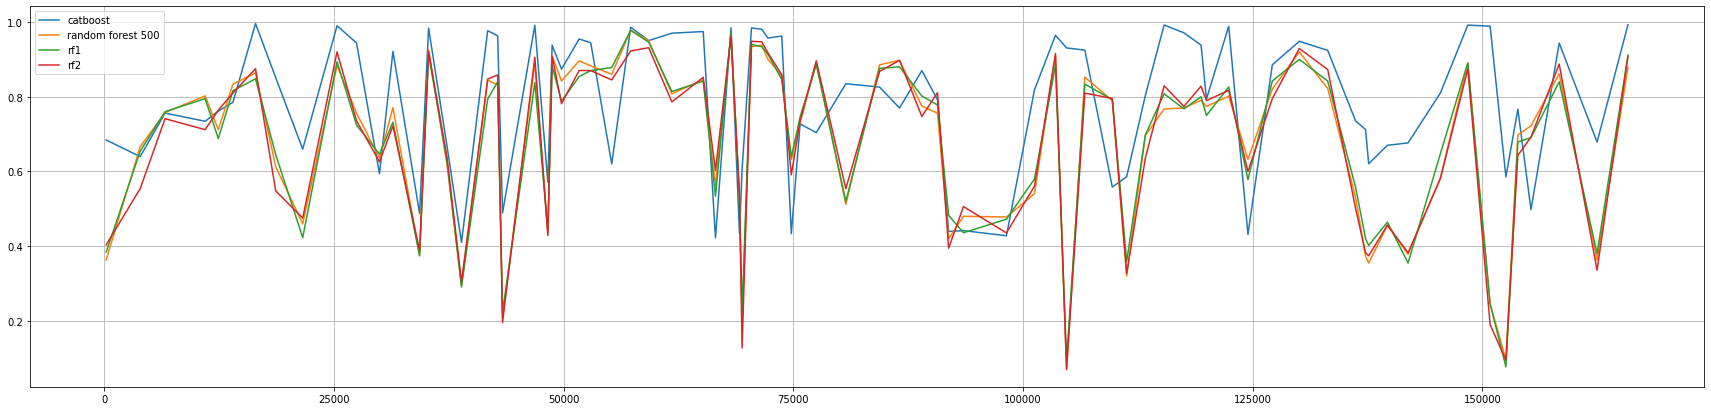

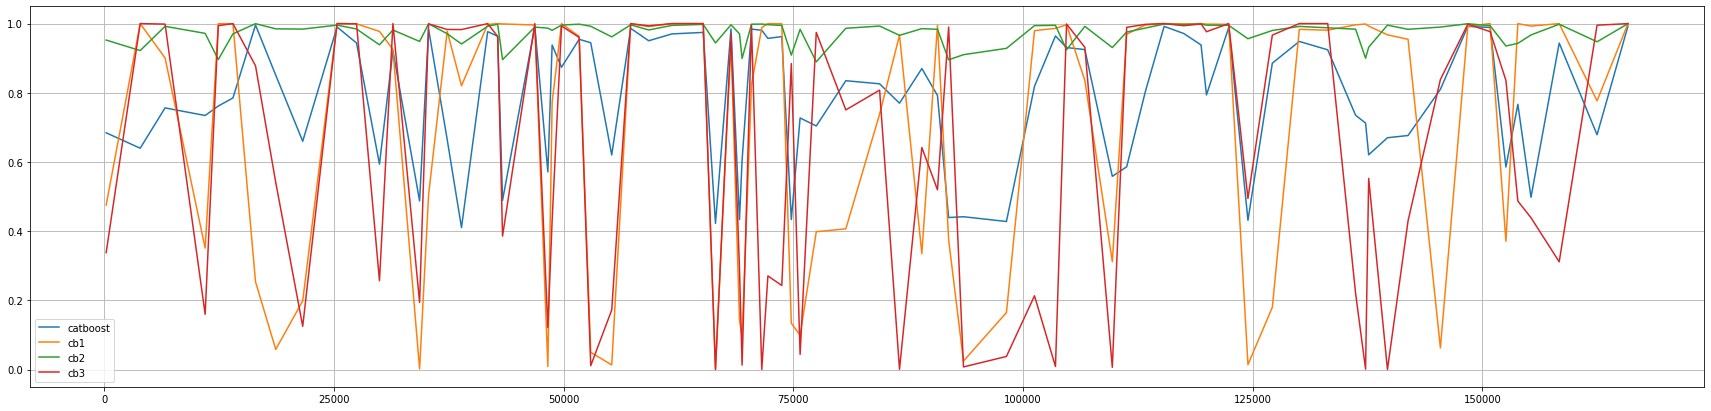

In [55]:
idx = predict_data['catboost']>=0.4
predict_data[idx].iloc[0:4000:50][['catboost', 'random forest 500', 'rf1', 'rf2']].plot(figsize=(30, 7))
plt.grid();
predict_data[idx].iloc[0:4000:50][['catboost', 'cb1', 'cb2', 'cb3']].plot(figsize=(30, 7))
plt.grid();

## Блендинг над предсказаниями с PolynomialFeatures

In [29]:
# !!! только для catboost-ов
predict_val = predict_val[['catboost', 'cb1', 'cb2', 'cb3', 'cb4', 'cb5']]
predict_data = predict_data[['catboost', 'cb1', 'cb2', 'cb3', 'cb4', 'cb5']]

In [11]:
# Загрузим данные из файла
predict_val = pd.read_pickle('drive/MyDrive/Data/predict_val.zip')
y_val = pd.read_pickle('drive/MyDrive/Data/y_val.zip')
predict_data = pd.read_pickle('drive/MyDrive/Data/predict_data.zip')

In [21]:
def poly_transform(data, degree=2):
    poly = PolynomialFeatures(degree=degree)
    poly_df = poly.fit_transform(data)
    poly_features = poly.get_feature_names_out(data.columns)
    predict_poly = pd.DataFrame(poly_df, columns=poly_features)
    predict_poly.drop('1', axis = 1, inplace=True)
    return predict_poly

In [45]:
predict_poly_val = poly_transform(predict_val)

In [ ]:
# Обучим LogisticRegression на полученных предсказаниях
blender = LogisticRegression()
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000, 2500, 5000]
    }
]
clf = GridSearchCV(blender, param_grid = param_grid, cv = 2, verbose=True, n_jobs=-1)
blender = clf.fit(predict_poly_val, y_val)

In [62]:
blender.best_estimator_

LogisticRegression(C=1.623776739188721, solver='liblinear')

In [ ]:
# Сохранение модели в файл
pd.to_pickle(blender, 'best_model.zip')

In [48]:
# Простая логическая регрессия
blender = LogisticRegression(max_iter=5000)
blender.fit(predict_poly_val, y_val)

LogisticRegression(max_iter=5000)

In [ ]:
# Обучим RandomForest на полученных предсказаниях
blender = RandomForestClassifier(
    n_estimators = 1000, 
    random_state = 0xFEED, 
    max_depth = 25,
    min_samples_leaf = 1, # Для классификатора рекомендуют 1, для регрессии - 5
    n_jobs=-1
)
blender.fit(predict_poly_val, y_val)

RandomForestClassifier(max_depth=25, n_estimators=1000, n_jobs=-1,
                       random_state=65261)

In [46]:
predict_data_poly = poly_transform(predict_data)

In [49]:
# Подготовка ответа для Каггл
submission = pd.read_csv('drive/MyDrive/Data/sample_submission.csv', delimiter=',')
submission['isFraud'] = blender.predict_proba(predict_data_poly)[:,1] # you must predict a probability for the isFraud variable
submission.to_csv('poly_blender_logreg_rf1-5_cb1-5.csv', index=False)



---

Kaggle: 0.906649, 0.930168 ...

best 0.913484, 0.939870